In [3]:
import pandas as pd 
import numpy as np 
import os
import math 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load Data

In [4]:
path = "."
fname = os.path.join(path, "raw_data.csv")
df = pd.read_csv(fname)

In [5]:
display(df.head())

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [6]:
len(df.company.unique())

1632

## Clean Company

In [7]:
t = df.groupby(['company']).count().sort_values(by=['timestamp'], ascending = False).rename(columns={'timestamp':'count'}).reset_index() #data clean up 
t[['company', 'count']] # need data cleaning?

,company,count
0,Amazon,8126
1,Microsoft,5216
2,Google,4330
3,Facebook,2990
4,Apple,2028
...,...,...
1626,Truecar,1
1627,Cirrus logic,1
1628,Cisco systems,1
1629,Trinet,1


In [8]:
print("Before cleaning: {}".format(len(t.company)))

Before cleaning: 1631


In [9]:
t['company_clean'] = t.company.str.rstrip().str.lstrip().str.upper()
print("After cleaning: {}".format(len(t.company_clean.unique())))

After cleaning: 1100


In [10]:
df['company_clean'] = df.company.str.rstrip().str.lstrip().str.upper()
s = df.groupby(['company_clean']).count().sort_values(by=['timestamp'], ascending = False).rename(columns={'timestamp':'count_'}).reset_index() #data clean up 
s = s[['company_clean', 'count_']] # need data cleaning?
s['cum_count'] = s['count_'].cumsum()
s['cum_perc'] = (s['cum_count']/s.count_.sum())*100

In [11]:
s[s.cum_perc <= 50.0]  #clean (or use) until 90th or 95th percentile? Use top 5 companies for further evaluation - regression for exp. total comp.

,company_clean,count_,cum_count,cum_perc
0,AMAZON,8199,8199,13.089707
1,MICROSOFT,5241,13440,21.456966
2,GOOGLE,4363,17803,28.422498
3,FACEBOOK,3004,20807,33.218385
4,APPLE,2047,22854,36.486422
5,ORACLE,1143,23997,38.311222
6,SALESFORCE,1065,25062,40.011495
7,INTEL,966,26028,41.553714
8,IBM,927,26955,43.033670
9,CISCO,923,27878,44.507240


In [12]:
company_names = t.company_clean.unique()
company_names

array(['AMAZON', 'MICROSOFT', 'GOOGLE', ..., 'IDEMIA',
       'QUEST DIAGNOSTICS', 'TASKRABBIT'], dtype=object)

In [14]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [15]:
#try levenshtein # not using 
cols = ["Company", "ClosestMatch", "Score"]
df_companyClosestMatch = pd.DataFrame(columns = cols)

for company in company_names:
    max_score = 0
    closestMatch = None
    #company_name = None 
    for val_to_compare in company_names:
        if val_to_compare == company:
            continue 
        else:
            score =  fuzz.token_sort_ratio(company, val_to_compare)
            if score > max_score:
                max_score = score 
                closestMatch = val_to_compare
    df_companyClosestMatch = df_companyClosestMatch.append(pd.DataFrame({"Company": [company],
                                                 "ClosestMatch": [closestMatch],
                                                 "Score": [max_score]
                                                   }))


In [16]:
df_companyClosestMatch

,Company,ClosestMatch,Score
0,AMAZON,AMZON,91
0,MICROSOFT,MICRON,67
0,GOOGLE,GOOGLE LLC,75
0,FACEBOOK,FACTSET,53
0,APPLE,RIPPLE,73
...,...,...,...
0,XING,ING,86
0,VIZIO,VERIZON,67
0,IDEMIA,NVIDIA,67
0,QUEST DIAGNOSTICS,NEXTERA ANALYTICS,53


In [17]:
#writing to a file
file_name = "df_companyClosestMatch.csv"
df_companyClosestMatch.to_csv(file_name, encoding='utf-8', index=False)

In [39]:
import nltk

In [40]:
#try jaccard : https://python.gotrained.com/nltk-edit-distance-jaccard-distance/  # not using 
cols = ["Company", "ClosestMatch", "Score"]
df_companyClosestMatch = pd.DataFrame(columns = cols)

for company in company_names:
    min_score = 100
    closestMatch = None
    #company_name = None 
    for val_to_compare in company_names:
        if val_to_compare == company:
            continue 
        else:
            score = nltk.jaccard_distance(set(company), set(val_to_compare))
            if score < min_score:
                min_score = score 
                closestMatch = val_to_compare
    df_companyClosestMatch = df_companyClosestMatch.append(pd.DataFrame({"Company": [company],
                                                 "ClosestMatch": [closestMatch],
                                                 "Score": [min_score]
                                                   }))


In [28]:
df_companyClosestMatch

,Company,ClosestMatch,Score
0,AMAZON,AMZON,0.000000
0,MICROSOFT,INFORMATICA,0.300000
0,GOOGLE,GOOGLE LLC,0.333333
0,FACEBOOK,BANK OF AMERICA,0.416667
0,APPLE,STAPLES,0.333333
...,...,...,...
0,XING,ING,0.250000
0,VIZIO,VERIZON,0.428571
0,IDEMIA,MEDALLIA,0.166667
0,QUEST DIAGNOSTICS,DELOITTE CONSULTING,0.214286


In [29]:
s = df.groupby(['company']).count().sort_values(by=['timestamp'], ascending = False).rename(columns={'timestamp':'count'}).reset_index() #data clean up 
t[['company', 'count']] # need data cleaning?

,company,count
0,Amazon,8126
1,Microsoft,5216
2,Google,4330
3,Facebook,2990
4,Apple,2028
...,...,...
1626,Truecar,1
1627,Cirrus logic,1
1628,Cisco systems,1
1629,Trinet,1


In [30]:
#writing to a file
file_name = "company_count_v2.csv"
s.to_csv(file_name, encoding='utf-8', index=False)

## Word Cloud

In [18]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [19]:
df['otherdetails'].dropna()

32                                        Tons of overtime
46                                                     PhD
58                                How do I access results?
60                                       Year 2 bonus, 24k
65       401k match 50%, vested immediately, up to the ...
                               ...                        
62581             Sign on bonus - 45k(Not included in TC).
62588                                         70000 signon
62591    40k cash split over 2 years. 75k rsus over 4 y...
62610    65k of stocks at 5/15/40/40 vesting schedule p...
62627                                        industry hire
Name: otherdetails, Length: 40137, dtype: object

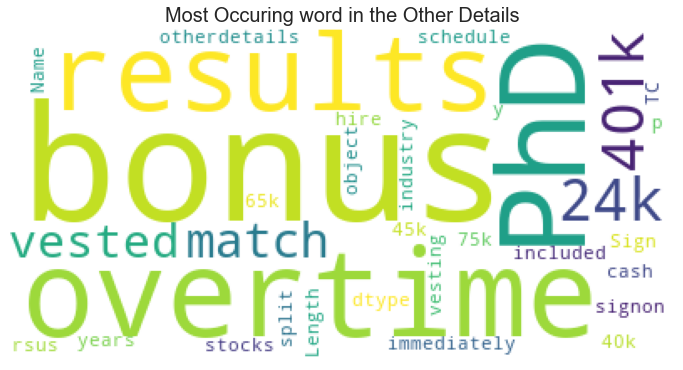

In [20]:
my_additional_stop_words = ['Year', 'Tons', 'access'] #, 'white', 'pink', 'blue', 'black', 'green']

stop_words = list(STOPWORDS) + my_additional_stop_words

#stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stop_words, background_color = 'white').generate(str(df['otherdetails'].dropna()))

print(wordcloud)
plt.rcParams['figure.figsize'] = (12, 12)
plt.axis('off')
plt.imshow(wordcloud)
plt.title('Most Occuring word in the Other Details', fontsize = 20)
plt.show()

In [ ]:
# will revisit later 

In [44]:
t = df['otherdetails'].dropna().str.contains('sign')
s = df.iloc[t[t==True].index][['otherdetails', 'bonus']]
s
#t[t.otherdetails == True]

#JoinedTables['ExerciseDay'] = JoinedTables['Notes'].str.contains('exercise').

,otherdetails,bonus
97,40K signon for years,40000.0
214,12k sign-on,30000.0
215,"10k signon, stock pre-IPO so not saleable",0.0
289,65 sign on,17500.0
300,Stock includes the year's total vest value fro...,20000.0
...,...,...
62425,Design manager,59733.0
62459,Relocation package's services are valued at 26...,25000.0
62468,30k signon,25000.0
62528,"Negotiated sign-on, 25k",13500.0


In [47]:
#writing to a file
file_name = "otherdetails_bonus.csv"
s.to_csv(file_name, encoding='utf-8', index=False)

## Yearly compensation

In [48]:
#data validation 
salary_cols = [ 'totalyearlycompensation', 'basesalary',
 'stockgrantvalue',
 'bonus']
t = df[salary_cols].copy()#.info()
t['total'] = t['basesalary'] + t['stockgrantvalue'] + t['bonus']
t.loc[t.total != t.totalyearlycompensation]

,totalyearlycompensation,basesalary,stockgrantvalue,bonus,total
0,127000,107000.0,20000.0,10000.0,137000.0
1,100000,0.0,0.0,0.0,0.0
2,310000,155000.0,0.0,0.0,155000.0
4,157000,0.0,0.0,0.0,0.0
5,208000,0.0,0.0,0.0,0.0
...,...,...,...,...,...
62636,172000,142000.0,15000.0,14200.0,171200.0
62638,237000,146900.0,73200.0,16000.0,236100.0
62639,220000,157000.0,25000.0,20000.0,202000.0
62640,280000,194688.0,57000.0,29000.0,280688.0


In [49]:
t['diff_perc'] = round(((t['totalyearlycompensation']-t['total'])/t['totalyearlycompensation'])*100)
t[['totalyearlycompensation', 'total', 'diff_perc' ]]


,totalyearlycompensation,total,diff_perc
0,127000,137000.0,-8.0
1,100000,0.0,100.0
2,310000,155000.0,50.0
3,372000,372000.0,0.0
4,157000,0.0,100.0
...,...,...,...
62637,327000,327000.0,0.0
62638,237000,236100.0,0.0
62639,220000,202000.0,8.0
62640,280000,280688.0,-0.0


In [50]:
def group_data(x):
    val = abs(x)
    if x <= 5: return "0-5"
    elif x<= 10: return "06-10"
    elif x<= 20: return "11-20"
    elif x<=40: return "21-40"
    elif x<=60: return "41-60"
    elif x<=80: return "61-80"
    else: return ">81"
    
t["perc_group"] = t["diff_perc"].apply(group_data)


In [51]:
t.groupby(['perc_group']).count() #use totalyearlycom? 

,totalyearlycompensation,basesalary,stockgrantvalue,bonus,total,diff_perc
perc_group,,,,,,
0-5,59859,59859,59859,59859,59859,59859
06-10,179,179,179,179,179,179
11-20,119,119,119,119,119,119
21-40,88,88,88,88,88,88
41-60,49,49,49,49,49,49
61-80,28,28,28,28,28,28
>81,2320,2320,2320,2320,2320,2320


In [53]:
#t.loc[t.diff_perc > 80].groupby(['diff_perc']).count()
t.loc[(t.diff_perc == 100) & (t.total == 0)]#.groupby(['diff_perc']).count() #breakdown no provided 

,totalyearlycompensation,basesalary,stockgrantvalue,bonus,total,diff_perc,perc_group
1,100000,0.0,0.0,0.0,0.0,100.0,>81
4,157000,0.0,0.0,0.0,0.0,100.0,>81
5,208000,0.0,0.0,0.0,0.0,100.0,>81
8,120000,0.0,0.0,0.0,0.0,100.0,>81
12,150000,0.0,0.0,0.0,0.0,100.0,>81
...,...,...,...,...,...,...,...
11007,240000,0.0,0.0,0.0,0.0,100.0,>81
14957,195000,0.0,0.0,0.0,0.0,100.0,>81
14974,240000,0.0,0.0,0.0,0.0,100.0,>81
14979,310000,0.0,0.0,0.0,0.0,100.0,>81


## Clean tags

In [56]:
current_tag_list = ['iOS', 'Android', 'Mobile (iOS + Android)', 'Web Development (Front-End)', 'ML / AI', 'Distributed Systems (Back-End)', 'API Development (Back-End)', 'Full Stack',
'Networking', 'Testing (SDET)', 'Data', 'Production', 'Security', 'DevOps', 'Site Reliability (SRE)', 'Blockchain', 'Other']

In [57]:
len(df.tag.dropna().unique())

3058

In [58]:
t = df.groupby(['tag']).count().sort_values(by=['timestamp'], ascending = False).rename(columns={'timestamp':'count_'}).reset_index()#data clean up 
s = t[['tag', 'count_']].loc[t.count_>100]#.head(20) # can be useful? clustering? 
s
#t[['tag', 'count']].tail(10) # need data cleaning?

,tag,count_
0,Full Stack,11382
1,Distributed Systems (Back-End),10838
2,API Development (Back-End),6277
3,ML / AI,4204
4,Web Development (Front-End),2971
5,Product,1801
6,Data,1586
7,DevOps,1573
8,Security,1204
9,Networking,1178


In [61]:
values_to_map = set(s.tag.unique()) - set(current_tag_list)
len(list(values_to_map))

22

In [60]:
mapping_dict = {'Analytics': 'Data', 
                'Operations': 'DevOps',
                'Embedded Systems': "?",
                'Validation': "Testing (SDET)",
                'Verification': "Testing (SDET)",
                'Analog': "?", 
                'User Experience (UX)': "???", 
                'Infrastructure': "?", 
                'Sales': "?",
                'Hardware': "?",
                'Growth': "?",
                'ASIC Design': "?",
                'Enterprise': "?",
                'Product': "?",
                'Technical': '?',
                'SoC Design': "?", 
                'Design': "?",
                'Consumer': "?",
                'General': "Other",
                'Cloud': "?",
                'Embedded' : "?", 
                'Analytic': "Data"}

In [ ]:
s['tag_clean'] = s['tag'].map(mapping_dict)
s